In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D

In [ ]:
!unzip /content/drive/MyDrive/digital-farmer/PlantVillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/5e9291cf-c9b5-4a3c-bf58-9bc155c4ce86___RS_HL 6796.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5ef306df-0c35-444a-a940-7f52b993ede1___RS_HL 6175.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5f1b1ee2-896c-43dd-8605-2bc4fde25277___RS_HL 3318.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5f818751-6536-4773-ab39-327199d79cfa___RS_HL 5655.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5fb2bc9c-b1e5-4798-9c7c-c8b08802631a___RS_HL 3697.JPG  
  inflating: PlantVillage/val/Soybean___healthy/603fd431-c503-4761-991f-b90670c6e96d___RS_HL 3282.JPG  
  inflating: PlantVillage/val/Soybean___healthy/608e2dc7-7591-48a8-958a-da698f8abfe6___RS_HL 3423.JPG  
  inflating: PlantVillage/val/Soybean___healthy/60a7d584-8124-4d3b-abae-4de8f0a8d892___RS_HL 4275.JPG  
  inflating: PlantVillage/val/Soybean___healthy/60a8e9b2-9a9b-47c7-b6d9-af8a850b02bf___RS_HL 6522.JPG  
  inflating: 

In [ ]:
base_path = '/content/PlantVillage/'

train_data_dir = base_path + "train"
val_data_dir = base_path + "val"

os.chdir(base_path)
!dir 

mobilenet.h5  train  val


In [ ]:
print(train_data_dir)
print(val_data_dir)

/content/PlantVillage/train
/content/PlantVillage/val


In [ ]:
img_size, batch_size, shuffle_size = 256, 32, 1000
img_shape = (img_size, img_size, 3)

In [ ]:
gen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input
)

train_generator = gen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size)
)

val_generator = gen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size)
)

Found 44135 images belonging to 39 classes.
Found 11065 images belonging to 39 classes.


In [ ]:
labels = train_generator.class_indices

In [ ]:
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_m = true_positives / (possible_positives + K.epsilon())
    return recall_m

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_m = true_positives / (predicted_positives + K.epsilon())
    return precision_m

def f1(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [ ]:
resnet50 = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape)
resnet50.trainable = False

x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(39, activation="softmax")(x)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model = Model(resnet50.input, x)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00015), loss='categorical_crossentropy', metrics=['acc', f1, precision, recall])

In [ ]:
checkpoint = ModelCheckpoint("resnet50_v1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
model_history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=20,
    validation_data=val_generator,
    validation_steps=25,
    callbacks = [checkpoint, early]
)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 2.8545 - acc: 0.3031 - f1: 0.1163 - precision: 0.6837 - recall: 0.0656

KeyboardInterrupt: ignored

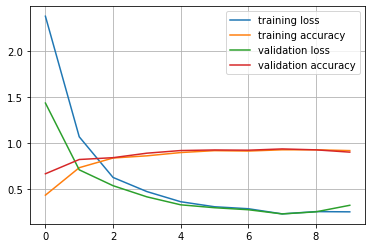

In [ ]:
plt.plot(model_history.history['loss'], label = 'training loss')
plt.plot(model_history.history['acc'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(model_history.history['val_loss'], label = 'validation loss')
plt.plot(model_history.history['val_acc'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [ ]:
model.save('pdd_resnet50_v1.h5')

In [ ]:
model.save('resnet50.h5')

In [ ]:
def preprocess_image(file):
  path = '/content/drive/MyDrive/digital-farmer/tests/'
  img = image.load_img(path + file, target_size=(256,256)) #return (img_size, img_size
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.resnet.preprocess_input(img_array_expanded_dims)
  # replace mobilenet with resnet


In [ ]:
#from tensorflow.keras.models import load_model
#model_two = load_model('..resnet50.h5')
# removed this whole block

In [ ]:
def get_prediction(image, level='all'):
  preprocessed_image = preprocess_image(image)
  predictions = model.predict(preprocessed_image)

  ind = np.argpartition(predictions[0], -5)[-5:]
  result = np.argmax(predictions[0])
  top5= predictions[0][ind]

  if level == 'single':
     for k,v in labels.items():
       if v == result: return k;
  else:
    for k,v in labels.items():
      if v in np.sort(ind):
        idx = np.where(ind == v)[0]
        print(f'{top5[idx]} ~> {k}')



 

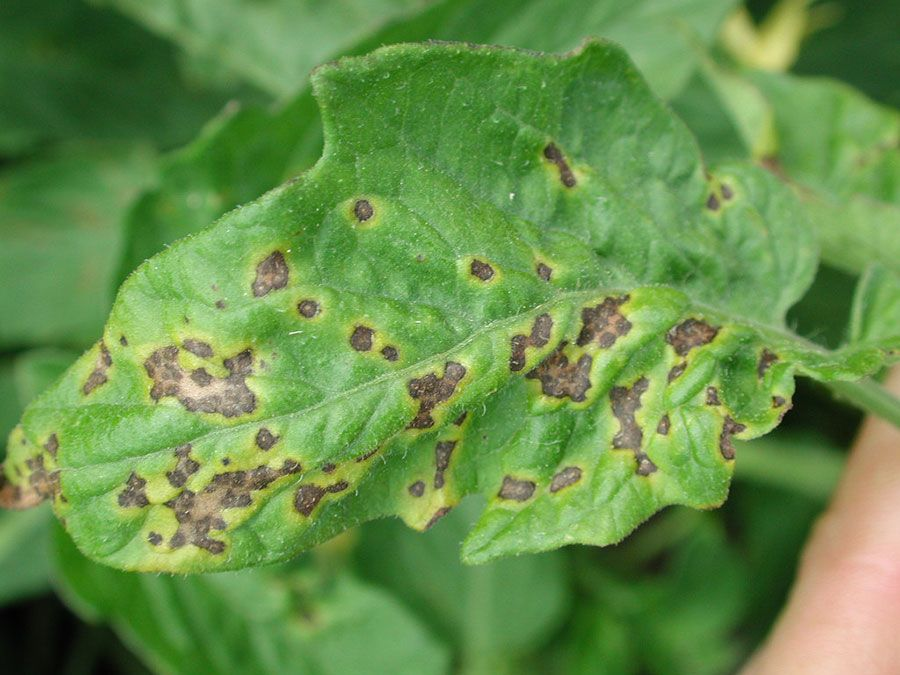

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/digital-farmer/tests/tomato_bacterial-spot.jpg', width=300, height=200)

In [ ]:
ans = get_prediction('tomato_bacterial-spot.jpg')
ans

[0.62022704] ~> Grape___Black_rot
[0.29831377] ~> Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
[0.01750747] ~> Potato___Early_blight
[0.0299502] ~> Strawberry___Leaf_scorch
[0.00738592] ~> Tomato___Early_blight
